In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_all = pd.read_csv('X_filtered.csv')
Y = pd.read_csv('Y.csv')

X_train, X_test, y_train, y_test = train_test_split(X_all, Y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.ravel(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.ravel(), dtype=torch.long)

class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_size1=64, hidden_size2=32, dropout_rate=0.2):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def train_and_evaluate(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                      learning_rate, batch_size, epochs=300, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_train_loss = float('inf')
    no_improve_count = 0
    final_metrics = {}
    
    for epoch in range(epochs):
        model.train()
        dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        epoch_loss = 0
        batch_count = 0
        
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_epoch_loss = epoch_loss / batch_count
        
        # 记录最佳训练loss
        if avg_epoch_loss < best_train_loss:
            best_train_loss = avg_epoch_loss
            no_improve_count = 0
            
            # 在最佳loss时计算训练集和测试集的准确率
            model.eval()
            with torch.no_grad():
                # 训练集准确率
                train_outputs = model(X_train_tensor)
                train_predicted = torch.argmax(train_outputs, axis=1)
                train_accuracy = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor)
                
                # 测试集准确率
                test_outputs = model(X_test_tensor)
                test_predicted = torch.argmax(test_outputs, axis=1)
                test_accuracy = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
                
                final_metrics = {
                    'best_train_loss': best_train_loss,
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy,
                    'best_epoch': epoch
                }
        else:
            no_improve_count += 1
        
        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    return final_metrics
# ... existing code ...

# 定义基准参数
base_params = {
    'learning_rate': 0.001,
    'batch_size': 64,
    'hidden_size1': 64,
    'hidden_size2': 32,
    'dropout_rate': 0.2
}

# 定义每个参数的搜索范围
param_ranges = {
    'learning_rate': [0.0001, 0.01, 0.1],
    'batch_size': [32, 128, 512, 1024],
    'dropout_rate': [0.1, 0.3, 0.4]
}

# 线性搜索每个参数
results = []
best_params = base_params.copy()
best_train_loss = float('inf')

# 创建结果文件
with open('linear_search_results.txt', 'w') as f:
    f.write("Linear Parameter Search Results:\n")
# 先计算基准参数的性能
print("\nCalculating baseline performance...")
model = NeuralNet(input_dim=X_train.shape[1],
                 hidden_size1=base_params['hidden_size1'],
                 hidden_size2=base_params['hidden_size2'],
                 dropout_rate=base_params['dropout_rate'])

baseline_metrics = train_and_evaluate(model, X_train_tensor, y_train_tensor,
                                   X_test_tensor, y_test_tensor,
                                   learning_rate=base_params['learning_rate'],
                                   batch_size=base_params['batch_size'])

baseline_str = ("Baseline Performance:\n"
               f"Train Loss: {baseline_metrics['best_train_loss']:.4f}\n"
               f"Train Accuracy: {baseline_metrics['train_accuracy']:.4f}\n" 
               f"Test Accuracy: {baseline_metrics['test_accuracy']:.4f}\n"
               f"Best Epoch: {baseline_metrics['best_epoch']}\n"
               f"{'='*50}\n")

print(baseline_str)
with open('linear_search_results.txt', 'a') as f:
    f.write(baseline_str)

# 对每个参数进行搜索
for param_name, param_values in param_ranges.items():
    print(f"\nSearching {param_name}...")
    
    for value in param_values:
        # 使用当前最佳参数，只改变正在搜索的参数
        current_params = base_params.copy()
        current_params[param_name] = value
        
        print(f"Testing {param_name} = {value}")
        
        # 创建模型
        model = NeuralNet(input_dim=X_train.shape[1], 
                         hidden_size1=current_params['hidden_size1'],
                         hidden_size2=current_params['hidden_size2'],
                         dropout_rate=current_params['dropout_rate'])
        
        # 训练和评估
        metrics = train_and_evaluate(model, X_train_tensor, y_train_tensor, 
                                   X_test_tensor, y_test_tensor,
                                   learning_rate=current_params['learning_rate'], 
                                   batch_size=current_params['batch_size'])
        
        # 保存结果
        result = {
            'parameter': param_name,
            'value': value,
            **current_params,
            **metrics
        }
        results.append(result)
        
        # 更新最佳参数
        if metrics['best_train_loss'] < best_train_loss:
            best_train_loss = metrics['best_train_loss']
            best_params[param_name] = value
        
        # 打印和保存当前结果
        result_str = (f"Parameter: {param_name}={value}\n"
                     f"Train Loss: {metrics['best_train_loss']:.4f}\n"
                     f"Train Accuracy: {metrics['train_accuracy']:.4f}\n"
                     f"Test Accuracy: {metrics['test_accuracy']:.4f}\n"
                     f"Best Epoch: {metrics['best_epoch']}\n"
                     f"{'='*50}\n")
        
        print(result_str)
        with open('linear_search_results.txt', 'a') as f:
            f.write(result_str)

# 打印最终的最佳参数
print("\nBest parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Best training loss: {best_train_loss:.4f}")

# 将结果保存到DataFrame中
results_df = pd.DataFrame(results)
results_df.to_csv('linear_search_results.csv', index=False)



Calculating baseline performance...
Early stopping at epoch 72
Baseline Performance:
Train Loss: 0.8187
Train Accuracy: 0.6510
Test Accuracy: 0.6237
Best Epoch: 62


Searching learning_rate...
Testing learning_rate = 0.0001
Early stopping at epoch 118
Parameter: learning_rate=0.0001
Train Loss: 0.8649
Train Accuracy: 0.6298
Test Accuracy: 0.6158
Best Epoch: 108

Testing learning_rate = 0.01
Early stopping at epoch 62
Parameter: learning_rate=0.01
Train Loss: 0.8117
Train Accuracy: 0.6572
Test Accuracy: 0.6102
Best Epoch: 52

Testing learning_rate = 0.1
Early stopping at epoch 25
Parameter: learning_rate=0.1
Train Loss: 0.9043
Train Accuracy: 0.6208
Test Accuracy: 0.5966
Best Epoch: 15


Searching batch_size...
Testing batch_size = 32
Early stopping at epoch 83
Parameter: batch_size=32
Train Loss: 0.8212
Train Accuracy: 0.6578
Test Accuracy: 0.6305
Best Epoch: 73

Testing batch_size = 128
Early stopping at epoch 133
Parameter: batch_size=128
Train Loss: 0.7983
Train Accuracy: 0.6688
Te

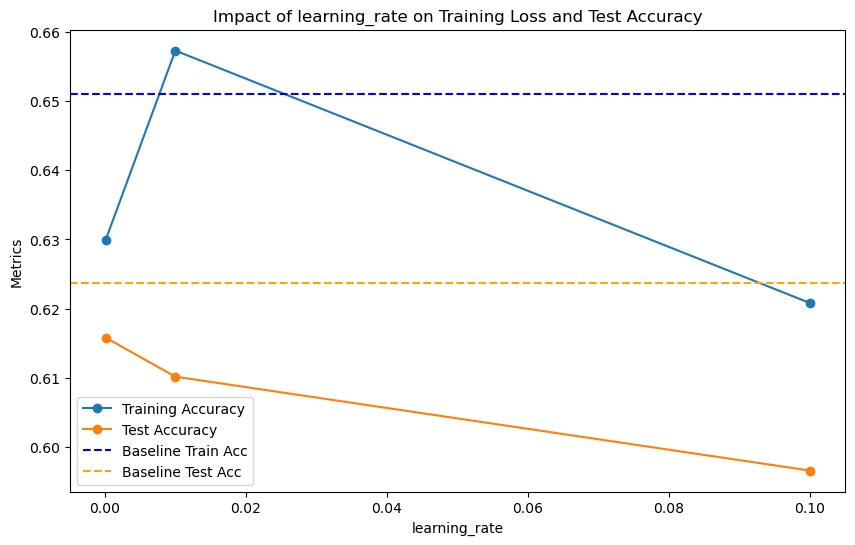

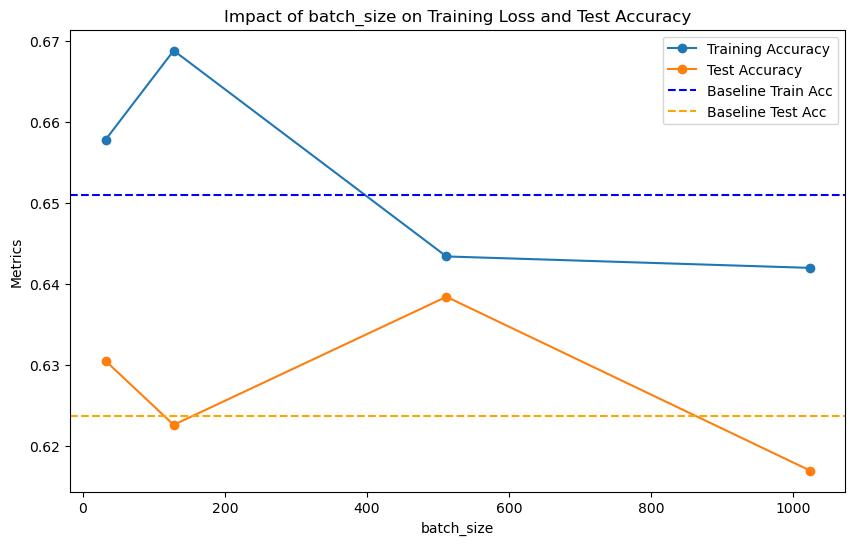

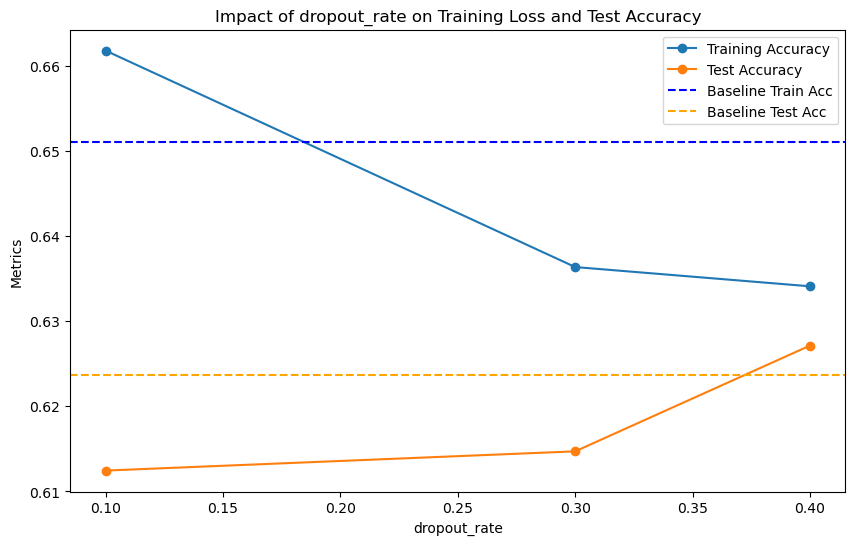

In [21]:
import matplotlib.pyplot as plt

# 读取baseline性能
baseline_train_acc = 0.6510
baseline_test_acc = 0.6237

results_df = pd.read_csv('linear_search_results.csv')
# 可视化每个参数的影响
for param_name in param_ranges.keys():
    param_results = results_df[results_df['parameter'] == param_name]
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(param_results['value'], param_results['train_accuracy'], 'o-', label='Training Accuracy')
    
    # Plot test accuracy 
    plt.plot(param_results['value'], param_results['test_accuracy'], 'o-', label='Test Accuracy')
    
    # 添加baseline参考线
    plt.axhline(y=baseline_train_acc, color='b', linestyle='--', label='Baseline Train Acc')
    plt.axhline(y=baseline_test_acc, color='orange', linestyle='--', label='Baseline Test Acc')
    
    plt.xlabel(param_name)
    plt.ylabel('Metrics')
    plt.title(f'Impact of {param_name} on Training Loss and Test Accuracy')
    plt.legend()

plt.show()